# IMPORTS

In [1]:
%load_ext blackcellmagic

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import express as px

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

import joblib

# Functions and Setups

In [3]:
color_pal = sns.color_palette('pastel') # https://seaborn.pydata.org/tutorial/color_palettes.html
plt.style.use('fivethirtyeight') # plt.style.available
plt.style.use('ggplot')

from typing import Union

In [4]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Create time series features based on time series index.

    Args:
        df (pd.DataFrame): source DataFrame

    Returns:
        pd.DataFrame: modified DataFrame
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return df

In [5]:
def get_usa_season(
    date: pd.Timestamp, return_type: str = "txt"
) -> Union[str, int, None]:
    """Return season in USA from date.

    Args:
        date (pd.Timestamp): date as pandas Timestamp format.
        return_type (str, optional): type of conversion to make. Only expects one of these ["txt", "number"]. Defaults to "txt".
            For `number` this is the mapping {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}

    Returns:
        Union[str, int, None]: season; One of ['Winter' OR 0, 'Spring' OR 1, 'Summer' OR 2, 'Fall' OR 3] or `None` if invalid.
    TODO:
    - try `pd.cut` to achieve this.
    """
    # Create a dictionary mapping seasons to their respective month ranges
    if return_type == "txt":
        seasons = {
            "Winter_mid": ((1, 1), (3, 20)),
            "Spring": ((3, 21), (6, 20)),
            "Summer": ((6, 21), (9, 22)),
            "Fall": ((9, 23), (12, 20)),
            "Winter": ((12, 21), (12, 31)),
        }
    elif return_type == "number":
        seasons = {
            99: ((1, 1), (3, 20)),
            1: ((3, 21), (6, 20)),
            2: ((6, 21), (9, 22)),
            3: ((9, 23), (12, 20)),
            0: ((12, 21), (12, 31)),
        }
    else:
        if isinstance(return_type, str):
            raise ValueError(
                f"""Check input of `return_type`. Only expects one of these ["txt", "number"]"""
            )
        else:
            raise TypeError(
                f"""Check input of `return_type`. Only expects one of these ["txt", "number"] as str object"""
            )

    # Convert date to a Pandas Timestamp object if it's not already
    if not isinstance(date, pd.Timestamp):
        date = pd.to_datetime(date)

    # Iterate over the seasons and check if the date falls within any range
    for season, (start_month_day, end_month_day) in seasons.items():
        start_month, start_day = start_month_day
        end_month, end_day = end_month_day

        if (
            (date.month == start_month and date.day >= start_day)
            or (date.month == end_month and date.day <= end_day)
            or (start_month < date.month < end_month)
        ):
            ret =  season
            if ret == "Winter_mid":
                return "Winter"
            elif ret == 99:
                return 0
            else:
                return ret
    
    return None

In [6]:
def US_holidays(df: pd.DataFrame, ret_int=True) -> pd.DataFrame:
    import holidays

    # Select country
    us_holidays = holidays.US()
    if ret_int:
        us_holidays_flag = [int(x in us_holidays) for x in df.index]
    else:
        us_holidays_flag = [x in us_holidays for x in df.index]
    df["holiday"] = us_holidays_flag
    return df

In [7]:
def dataset_processor(df: pd.DataFrame) -> pd.DataFrame:
    """Helper function. Process dataset

    Args:
        df (pd.DataFrame): pandas DataFrame

    Returns:
        pd.DataFrame: pandas DataFrame
    """
    df = create_features(df)
    df["season"] = [get_usa_season(x, "number") for x in df.index]
    return US_holidays(df)

# OBTAIN

About Dataset:

PJM Hourly Energy Consumption Data BY Rob Mulla. [Source](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [8]:
df = pd.read_csv('./data/PJM/PJME_hourly.csv')
df = df.set_index('Datetime')
df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)

In [9]:
df.head(3)

PJME_MW
Datetime                    
2002-01-01 01:00:00  30393.0
2002-01-01 02:00:00  29265.0
2002-01-01 03:00:00  28357.0

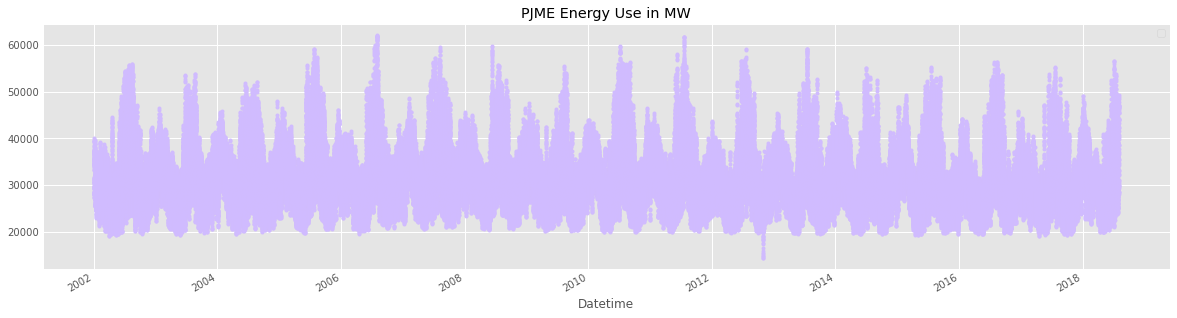

In [10]:
ax = df.plot(
    style=".", figsize=(18, 5), color=color_pal[4], title="PJME Energy Use in MW"
)
# ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.legend([])
plt.show()

In [11]:
fig = px.line(
    data_frame=df.rename(columns={"PJME_MW": "MW"}, inplace=False),
    title="PJME Energy Use in MW",
    template="plotly_dark",
)
fig.update_layout(showlegend=False)
fig.update_traces(line_color="azure", line_width=1)
fig.show()

# SCRUB

## EDA

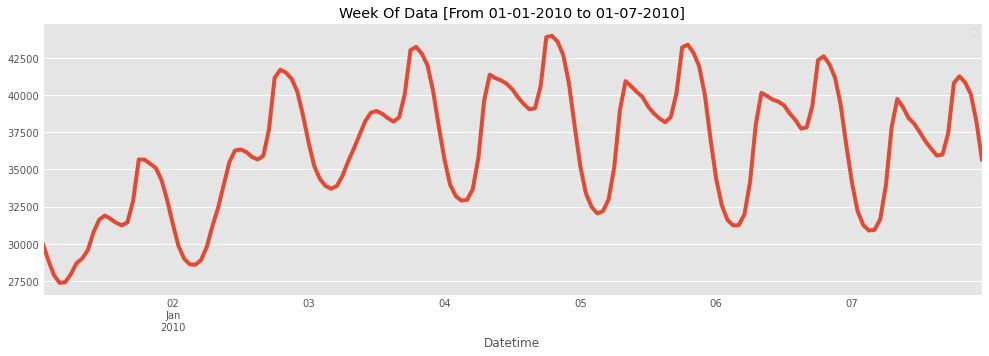

In [12]:
df.loc[(df.index > "01-01-2010") & (df.index < "01-08-2010")].plot(
    figsize=(15, 5), title="Week Of Data [From 01-01-2010 to 01-07-2010]"
)
plt.legend([])
plt.show()

## Feature Engineering

### Feature Creation

In [13]:
df = dataset_processor(df)
df.head()

PJME_MW  hour  dayofweek  quarter  month  year  \
Datetime                                                              
2002-01-01 01:00:00  30393.0     1          1        1      1  2002   
2002-01-01 02:00:00  29265.0     2          1        1      1  2002   
2002-01-01 03:00:00  28357.0     3          1        1      1  2002   
2002-01-01 04:00:00  27899.0     4          1        1      1  2002   
2002-01-01 05:00:00  28057.0     5          1        1      1  2002   

                     dayofyear  dayofmonth  weekofyear  season  holiday  
Datetime                                                                 
2002-01-01 01:00:00          1           1           1       0        1  
2002-01-01 02:00:00          1           1           1       0        1  
2002-01-01 03:00:00          1           1           1       0        1  
2002-01-01 04:00:00          1           1           1       0        1  
2002-01-01 05:00:00          1           1           1       0        1

In [14]:
# save as csv
df.reset_index().to_csv("./data/temp/df.csv", index=False)

### Feature / Target Relationship

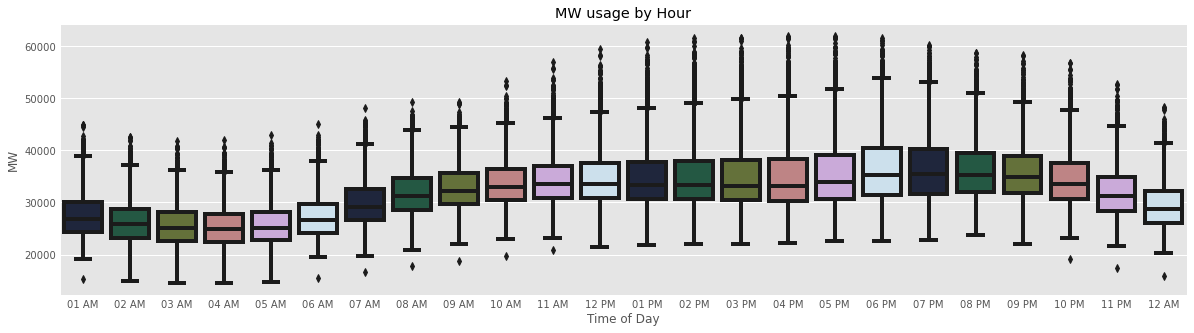

In [15]:
_ = df.copy()
_.hour = [x.strftime("%I %p") for x in df.index]
_.rename(columns={"PJME_MW": "MW", "hour": "Time of Day"}, inplace=True)

fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(data=_, x="Time of Day", y="MW", palette=sns.color_palette("cubehelix"))
ax.set_title("MW usage by Hour")
plt.show()
del _

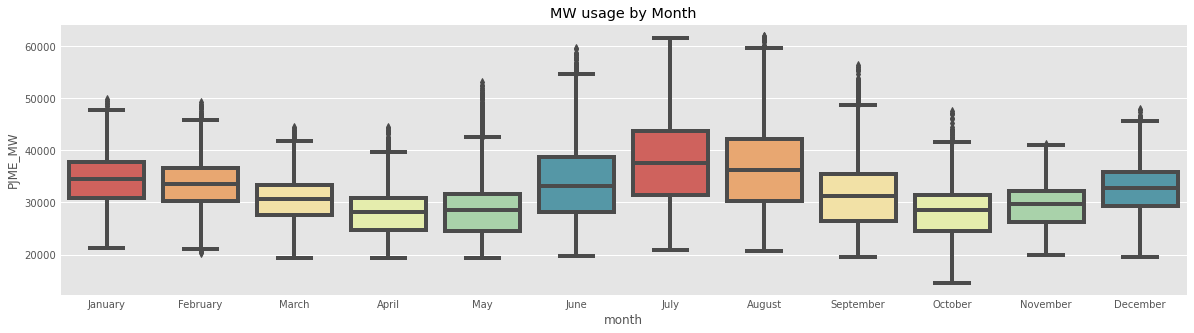

In [16]:
import calendar

month_names = list(calendar.month_name)[1:]

_ = df.copy()
_.month = df.index.month_name()

fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(
    data=_,
    x="month",
    y="PJME_MW",
    palette=sns.color_palette("Spectral"),
    order=month_names,
)
ax.set_title("MW usage by Month")
plt.show()
del _

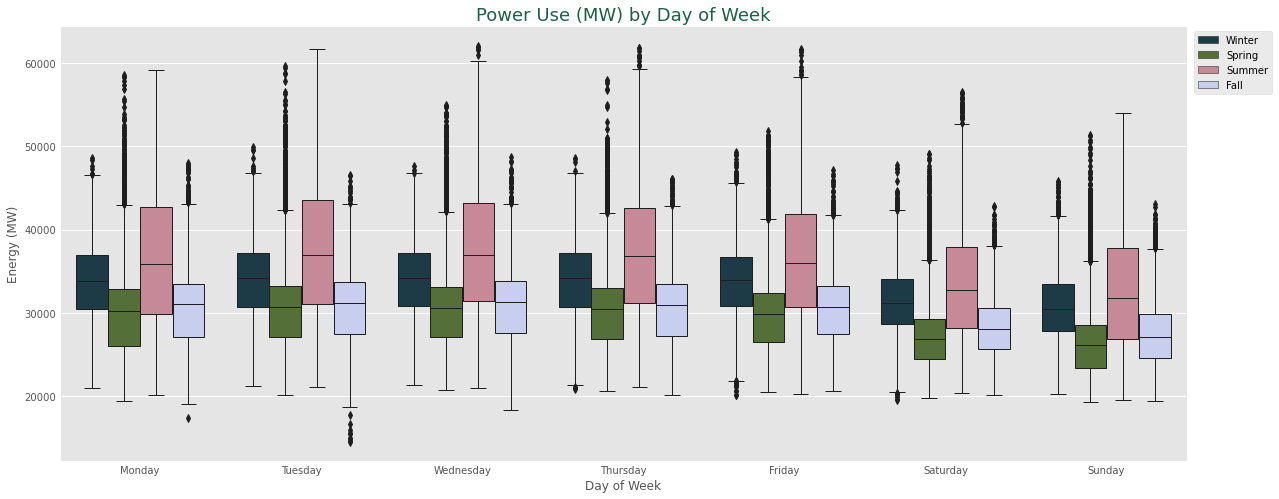

In [17]:
_ = df.copy()
_.dayofweek = df.index.day_name()
_.month = df.index.month_name()
map_q = {1: "Q1", 2: "Q2", 3: "Q3", 4: "Q4"}
_.quarter = df["quarter"].map(map_q)
_["season"] = [get_usa_season(x) for x in df.index]

fig, ax = plt.subplots(figsize=(18, 8))

sns.boxplot(
    data=_.dropna(),
    x="dayofweek",
    y="PJME_MW",
    hue="season",
    ax=ax,
    linewidth=1,
    palette="cubehelix",
    order=list(calendar.day_name)
)

ax.set_title(
    "Power Use (MW) by Day of Week",
    fontdict={
        "fontsize": 18,
        "fontweight": 5,
        "color": sns.color_palette("cubehelix")[1],
    },
)
ax.set_xlabel("Day of Week")
ax.set_ylabel("Energy (MW)")
ax.legend(bbox_to_anchor=(1.08, 1))

plt.show()

del _

# ML

## Preprocessing

### Train-Test Split

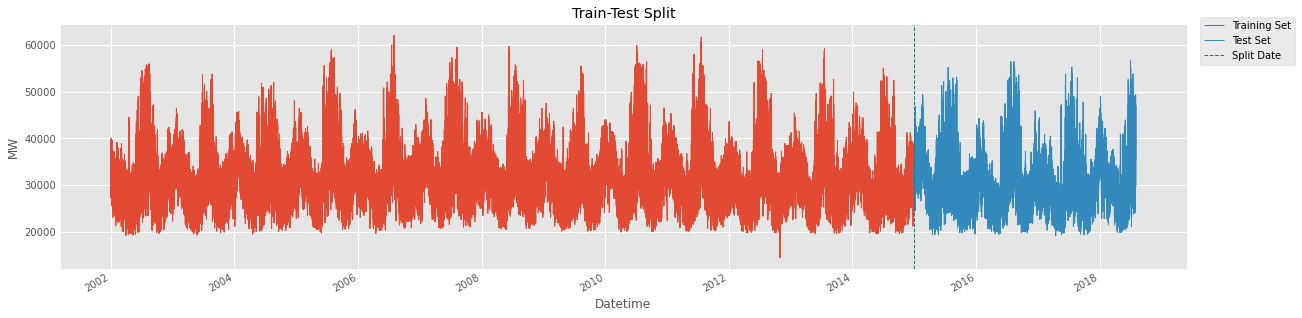

In [18]:
train = df.query("Datetime < '01-01-2015'")[['PJME_MW']]
test = df.query("Datetime >= '01-01-2015'")[['PJME_MW']]

fig, ax = plt.subplots(figsize=(18, 5))
train.plot(ax=ax, label='Training Set', title='Train-Test Split', legend='', lw=1)
test.plot(ax=ax, label='Test Set', legend="", lw=1)
ax.axvline('01-01-2015', color='teal', ls='--', lw=1)
plt.legend(['Training Set', 'Test Set', "Split Date"], bbox_to_anchor=(1.1, 1.05))
plt.ylabel("MW")
plt.show()

## Setup

In [19]:
train = dataset_processor(train)
test = dataset_processor(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'season', 'holiday']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [20]:
display(
    X_train.head(),
    f"""X_train shape: {X_train.shape}""",
    y_train.head(),
    f"""y_train shape: {y_train.shape}""",
    X_test.head(),
    f"""X_test shape: {X_test.shape}""",
    y_test.head(),
    f"""y_test shape: {y_test.shape}""",
)

dayofyear  hour  dayofweek  quarter  month  year  season  \
Datetime                                                                        
2002-01-01 01:00:00          1     1          1        1      1  2002       0   
2002-01-01 02:00:00          1     2          1        1      1  2002       0   
2002-01-01 03:00:00          1     3          1        1      1  2002       0   
2002-01-01 04:00:00          1     4          1        1      1  2002       0   
2002-01-01 05:00:00          1     5          1        1      1  2002       0   

                     holiday  
Datetime                      
2002-01-01 01:00:00        1  
2002-01-01 02:00:00        1  
2002-01-01 03:00:00        1  
2002-01-01 04:00:00        1  
2002-01-01 05:00:00        1

'X_train shape: (113926, 8)'

Datetime
2002-01-01 01:00:00    30393.0
2002-01-01 02:00:00    29265.0
2002-01-01 03:00:00    28357.0
2002-01-01 04:00:00    27899.0
2002-01-01 05:00:00    28057.0
Name: PJME_MW, dtype: float64

'y_train shape: (113926,)'

dayofyear  hour  dayofweek  quarter  month  year  season  \
Datetime                                                                        
2015-01-01 00:00:00          1     0          3        1      1  2015       0   
2015-01-01 01:00:00          1     1          3        1      1  2015       0   
2015-01-01 02:00:00          1     2          3        1      1  2015       0   
2015-01-01 03:00:00          1     3          3        1      1  2015       0   
2015-01-01 04:00:00          1     4          3        1      1  2015       0   

                     holiday  
Datetime                      
2015-01-01 00:00:00        1  
2015-01-01 01:00:00        1  
2015-01-01 02:00:00        1  
2015-01-01 03:00:00        1  
2015-01-01 04:00:00        1

'X_test shape: (31440, 8)'

Datetime
2015-01-01 00:00:00    32802.0
2015-01-01 01:00:00    31647.0
2015-01-01 02:00:00    30755.0
2015-01-01 03:00:00    30189.0
2015-01-01 04:00:00    29890.0
Name: PJME_MW, dtype: float64

'y_test shape: (31440,)'

## XGBoost

### ML train

In [21]:
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=100_000,
    early_stopping_rounds=50,
    objective="reg:squarederror", # "reg:linear",
    max_depth=5,
    learning_rate=0.001,
    n_jobs=-1
)

In [22]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)

[0]	validation_0-rmse:32894.96153	validation_1-rmse:31947.05863


[50]	validation_0-rmse:31325.94112	validation_1-rmse:30379.06523
[100]	validation_0-rmse:29835.15623	validation_1-rmse:28892.29241
[150]	validation_0-rmse:28418.82854	validation_1-rmse:27480.72707
[200]	validation_0-rmse:27071.87419	validation_1-rmse:26138.59960
[250]	validation_0-rmse:25790.52518	validation_1-rmse:24863.59850
[300]	validation_0-rmse:24572.32747	validation_1-rmse:23649.23939
[350]	validation_0-rmse:23415.40460	validation_1-rmse:22495.90294
[400]	validation_0-rmse:22315.46977	validation_1-rmse:21399.12765
[450]	validation_0-rmse:21269.96595	validation_1-rmse:20356.70731
[500]	validation_0-rmse:20277.77348	validation_1-rmse:19369.30111
[550]	validation_0-rmse:19335.85807	validation_1-rmse:18432.59548
[600]	validation_0-rmse:18440.82513	validation_1-rmse:17543.27552
[650]	validation_0-rmse:17586.96731	validation_1-rmse:16695.06226
[700]	validation_0-rmse:16776.69702	validation_1-rmse:15890.68797
[750]	validation_0-rmse:16010.45529	validation_1-rmse:15130.47614
[800]	valid

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

### Save model

In [23]:
joblib.dump(reg, './model/XGBRegressor.joblib', compress=('gzip', 9))

['./model/XGBRegressor.joblib']

#### Load model

In [24]:
# reg = joblib.load('./model/XGBRegressor.joblib')

### Inference

#### Feature Importance

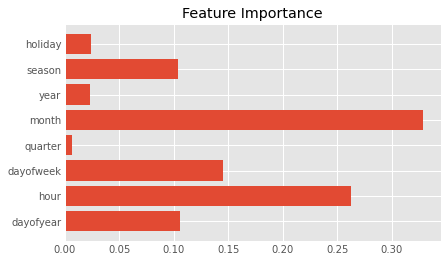

In [25]:
plt.barh(reg.feature_names_in_, reg.feature_importances_)
plt.title(label="Feature Importance")
plt.show()

In [26]:
perm_importance = permutation_importance(reg, X_test, y_test)

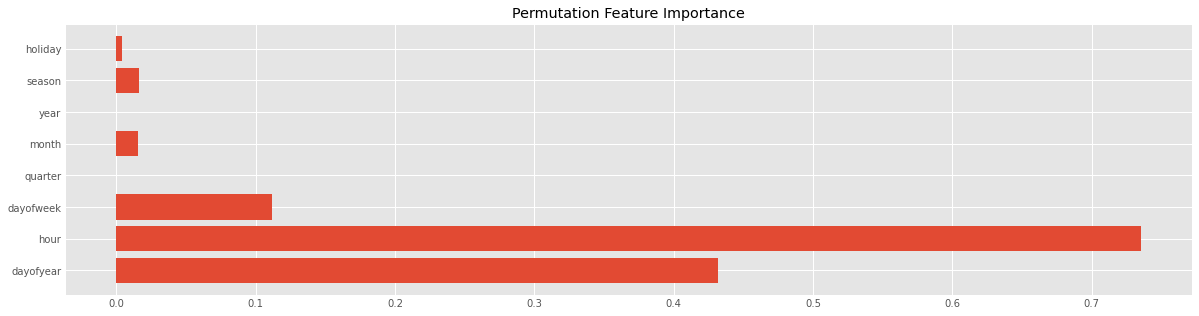

In [27]:
fig, ax = plt.subplots(figsize=(18, 5))
plt.barh(reg.feature_names_in_, perm_importance.importances_mean)
plt.title(label="Permutation Feature Importance")
plt.show()

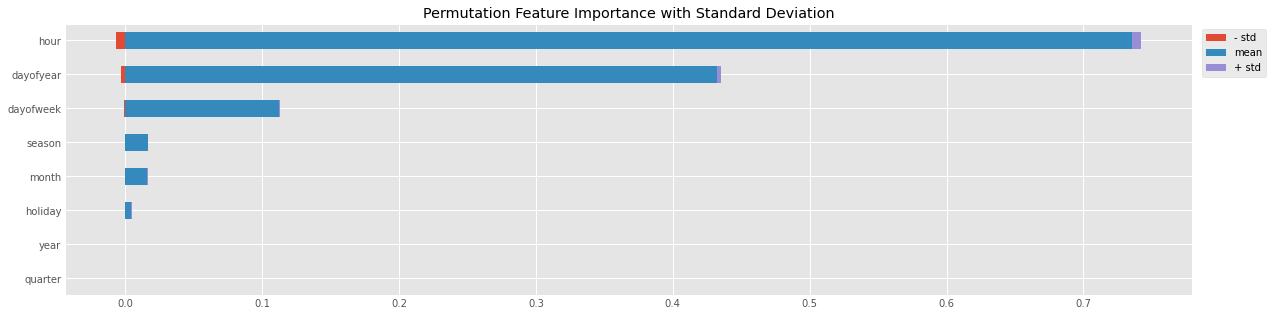

In [28]:
_ = pd.DataFrame(
    [
        reg.feature_names_in_,
        -perm_importance.importances_std,
        perm_importance.importances_mean,
        perm_importance.importances_std,
    ]
)
_ = _.T
_.set_index(0, inplace=True)
_.columns = ["- std", "mean", "+ std"]
_.sort_values(by=["mean"], axis='index', ascending=True, inplace=True)
ax = _.plot(kind="barh", stacked=True, figsize=(18, 5))
plt.title(label="Permutation Feature Importance with Standard Deviation")
ax.set(ylabel=None)
ax.legend(bbox_to_anchor=(1.07, 1))
plt.show()

### Forecast on Test Dataset

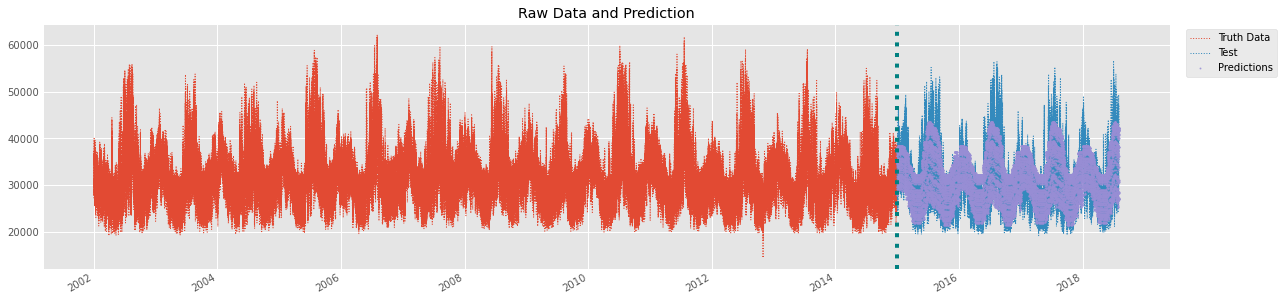

In [29]:
_test = test.copy()
_df = df.copy()
_test["prediction"] = reg.predict(X_test)
_df = _df.merge(_test[["prediction"]], how="left", left_index=True, right_index=True)

ax = train[["PJME_MW"]].plot(figsize=(18, 5), style=":", label="Train", linewidth=1)
test[["PJME_MW"]].plot(ax=ax, style=":", label='Test', linewidth=1)
_df["prediction"].plot(ax=ax, style="o", label="pred", alpha=.7, ms=1)

ax.axvline("01-01-2015", color="teal", ls=":")
plt.legend(["Truth Data", "Test", "Predictions"], bbox_to_anchor=(1.01, 1.0))
ax.set_title("Raw Data and Prediction")
ax.set(xlabel=None)
plt.show()

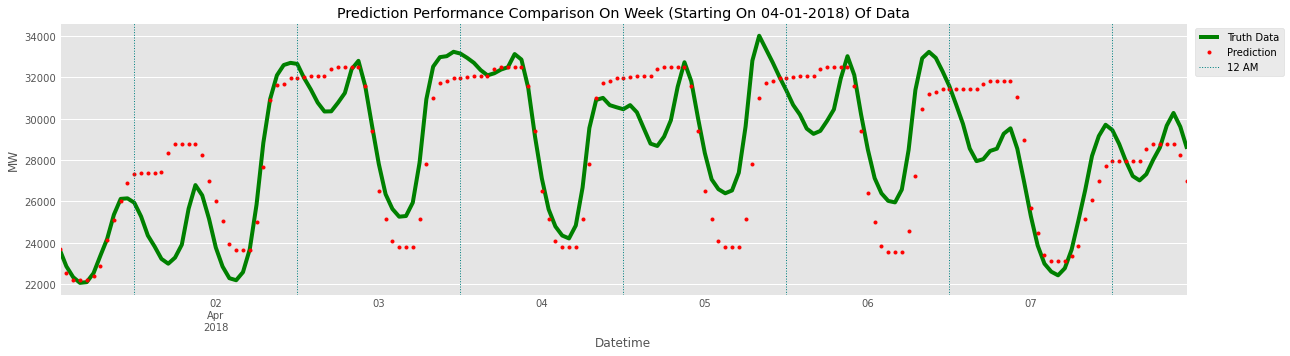

In [30]:
COMPARISON_WEEK_START = "04-01-2018"
COMPARISON_WEEK_END = (
    (pd.to_datetime(COMPARISON_WEEK_START) + timedelta(7)).date().strftime("%m-%d-%Y")
)

_ = _df.query("@COMPARISON_WEEK_START < Datetime  < @COMPARISON_WEEK_END")

ax = _["PJME_MW"].plot(
    figsize=(18, 5),
    title=f"Prediction Performance comparison on Week (starting on {COMPARISON_WEEK_START}) Of Data".title(),
    color="g",
)
_["prediction"].plot(style=".", color="r")
for date in [x for x in _.index if x.strftime("%I %p") == "12 PM"]:
    ax.axvline(date, color="teal", linestyle=":", lw=1)
plt.legend(["Truth Data", "Prediction", "12 AM"], bbox_to_anchor=(1.09, 1.0))
plt.ylabel("MW")
del _
plt.show()

### Forecast in the future

In [31]:
pred_df = pd.DataFrame([{"Datetime": (X_test.index[-1] + timedelta(hours=1))}])
pred_df.set_index("Datetime", inplace=True)
pred_df = dataset_processor(pred_df)
pred_df

hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2018-08-03 01:00:00     1          4        3      8  2018        215   

                     dayofmonth  weekofyear  season  holiday  
Datetime                                                      
2018-08-03 01:00:00           3          31       2        0

In [32]:
print(f"""Next hour prediction for `{TARGET}` is {reg.predict(pred_df[FEATURES])[0]:.2f}""")

Next hour prediction for `PJME_MW` is 28567.31


## Model Performance

### RMSE

In [33]:
score = np.sqrt(mean_squared_error(_test["PJME_MW"], _test["prediction"]))
print(f"RMSE Score on Test set: {score:0.2f}")

RMSE Score on Test set: 3740.78


### Error

In [34]:
_test["error"] = np.abs(_test[TARGET] - _test["prediction"])
_test["date"] = _test.index.date

print("Worst Predictions:")
print(
    _test.groupby(["date"])["error"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .to_string()
)

print("\nBest Predictions:")
print(
    _test.groupby(["date"])["error"]
    .mean()
    .sort_values(ascending=True)
    .head(10)
    .to_string()
)

Worst Predictions:
date
2016-08-13    12443.215983
2016-08-14    12330.885661
2016-09-10    11259.017253
2015-02-20    11029.920980
2016-09-09    10574.093994
2018-01-06    10467.989909
2015-02-21     9923.036377
2016-08-12     9830.668701
2015-02-16     9829.127767
2018-01-07     9621.285156

Best Predictions:
date
2017-10-24    341.563965
2015-10-28    497.336100
2016-10-27    561.970866
2016-03-20    610.887939
2015-05-06    618.300456
2018-05-16    636.257487
2017-10-15    647.249837
2017-04-07    687.466064
2017-01-06    699.333008
2015-01-18    708.009277


# Next Steps
- try out different models
    - Prophet | NeuralProphet [*](https://www.kaggle.com/code/antonmurashko/time-series-forecasting-with-prophet-yt) [1](https://bobrupakroy.medium.com/yes-our-favorite-fbprophet-is-back-with-multivariate-forecasting-785fbe412731) [2](https://www.microprediction.com/blog/prophet)
    - ANN: LSTM
    - ARIMA models; and its extensions like SARIMA, SARIMAX
    - scikit-learn based NN
    - LightGBM
    - AutoARIMA
    - Tsfresh | Darts | Kats [1](https://www.analyticsvidhya.com/blog/2022/05/5-python-libraries-for-time-series-analysis/) [2](https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b)
- More robust cross validation for models
- feature selection {keep log of changes}
- Add more features (weather forecast data, ~~holidays~~, major events, ~~season~~)

# Notes
- add holidays
```python
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
```

- alternative feature engineering. [source](https://www.kaggle.com/code/antonmurashko/time-series-forecasting-with-prophet-yt)
```python
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

def convert_days_to_season(days):
    # Define the start day and length of each season
    spring_start = 80  # March 21st (approximate)
    summer_start = 172  # June 21st (approximate)
    fall_start = 264  # September 23rd (approximate)
    winter_start = 355  # December 21st (approximate)

    # Determine the season based on the given number of days
    if days >= spring_start and days < summer_start:
        season = "Spring"
    elif days >= summer_start and days < fall_start:
        season = "Summer"
    elif days >= fall_start and days < winter_start:
        season = "Fall"
    else:
        season = "Winter"

    return season
```

# Disclaimer
This project is heavily influenced by [`ROB MULLA`](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt). [[YouTube - p1](https://www.youtube.com/watch?v=vV12dGe_Fho), [Youtube - p2](https://www.youtube.com/watch?v=z3ZnOW-S550) as of June 17, 2023.]